# 1. Designing the Experiment
In order to arrive to a randomness-free conclusion, the following must be set:

- Null Hypothesis: The conversion rate of (Var 1: Var 2: Var 3) is the same as the conversion rate of the control group
- Alternative Hypothesis: The conversion rate of (Var 1: Var 2: Var 3) is better or worse than the conversion rate of the control group
- Confidence level: 95%; Alpha: 0.05
- Hypothesis Test: Two-Tailed Proportion
- Approach: P-value


# 2. Preparing the Data

 Before analysing the data, the following steps must be done:
- Load the necessary imports
- Read the given data
- Describe the data
- Check for inconsistent data

In [1]:
#Loading the necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

#Reading the csv file as dataframe
df = pd.read_csv('./data/redesign (1).csv')
df.head(n=5)
#print(df.tail()); print(df.info()); print(df.describe())

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


In [2]:
print(df.info()); print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB
None
          converted
count  40484.000000
mean       0.113353
std        0.317028
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


In [3]:
pd.crosstab(df['treatment'],df['new_images'])

new_images,no,yes
treatment,,
no,10121,10121
yes,10121,10121


Upon checking the dataframe, the following information were observed:
- The dataframe consists of three columns namely: treatment, new_images, and converted
- Both the values of treatment and new_images columns are of datatype: object
- The values of the converted column is made up of binary data of datatype: int64
- The total count of the dataframe is 40,484 observations
- The crosstab shows that the variations and the control group have equal numbers of observations: 10,121

Before analysing the data, it must be neat and clean. Errors must be checked before manipulating the data.

In [4]:
print(df['treatment'].value_counts())
print(df['new_images'].value_counts())
print(df['converted'].value_counts())

treatment
yes    20242
no     20242
Name: count, dtype: int64
new_images
yes    20242
no     20242
Name: count, dtype: int64
converted
0    35895
1     4589
Name: count, dtype: int64


The data looks neat and clean! Next step is to prepare the data for further analysis.

From the initial inspection of the given data, it requires segregation for each variation and the control group. Once done, the data will be more orderly and organized, and easier to process for A/B Testing.

In [5]:
df['variation'] = 0

for row in df.index:
    if df.iloc[row,0] == 'yes' and df.iloc[row,1] == 'yes':
        df.iloc[row, 3] = 'Var 1'
    elif df.iloc[row,0] == 'yes' and df.iloc[row,1] == 'no':
        df.iloc[row, 3] = 'Var 2'
    elif df.iloc[row,0] == 'no' and df.iloc[row,1] == 'yes':
        df.iloc[row, 3] = 'Var 3'
    else:
        df.iloc[row, 3] = 'Control'
           
print(df.head())

C:\Users\User\AppData\Local\Temp\ipykernel_4008\3646494894.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Var 1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[row, 3] = 'Var 1'


  treatment new_images  converted variation
0       yes        yes          0     Var 1
1       yes        yes          0     Var 1
2       yes        yes          0     Var 1
3       yes         no          0     Var 2
4        no        yes          0     Var 3


What was done is the creation of a new column named 'variation' which contains the subgroups as values defined:

- Var 1 - these are observations containing the data from users who have seen the new set of images and the new design of the landing page.
- Var 2 - these are observations containing the data from users who have seen the old set of images and the new design of the landing page.
- Var 3 - these are observations containing the data from users who have seen the new set of images and the old design of the landing page.
- Control - these are observations containing the data from users who have seen the old set of images and the old design of the landing page. This category is set as the control group.

In order to simplify the data, a subset of the modified dataframe consisting of the columns 'variation' and 'converted' must be created. The data will be split into 4 subgroups.

In [6]:
#Subsetting variation and converted columns
simplified_df = df[['variation','converted']]

#Splitting subset into 4 subgroups
var1_df = simplified_df[simplified_df['variation'] == 'Var 1']
var2_df = simplified_df[simplified_df['variation'] == 'Var 2']
var3_df = simplified_df[simplified_df['variation'] == 'Var 3']
control_df = simplified_df[simplified_df['variation'] == 'Control']

var1_df.head()

,variation,converted
0,Var 1,0
1,Var 1,0
2,Var 1,0
11,Var 1,0
15,Var 1,0


In [7]:
var2_df.head()

,variation,converted
3,Var 2,0
5,Var 2,0
12,Var 2,0
13,Var 2,0
17,Var 2,1


In [8]:
var3_df.head()

,variation,converted
4,Var 3,0
6,Var 3,0
9,Var 3,0
10,Var 3,1
16,Var 3,0


After splitting the data into 4 subgroups, the data from each variation must be concatenated one by one along with the data from the control group.

In [9]:
ab_var1_con = pd.concat([var1_df,control_df], axis=0)
ab_var2_con = pd.concat([var2_df,control_df], axis=0)
ab_var3_con = pd.concat([var3_df,control_df], axis=0)
ab_var1_con.reset_index(drop=True,inplace=True)
ab_var2_con.reset_index(drop=True,inplace=True)
ab_var3_con.reset_index(drop=True,inplace=True)

print(ab_var1_con['variation'].value_counts())
print(ab_var2_con['variation'].value_counts())
print(ab_var3_con['variation'].value_counts())

variation
Var 1      10121
Control    10121
Name: count, dtype: int64
variation
Var 2      10121
Control    10121
Name: count, dtype: int64
variation
Var 3      10121
Control    10121
Name: count, dtype: int64


# 3. Visualizing the Data
Now that the data have been regrouped and concatenated for convenience, visualizing the data will be focused on the goal of the experiment.

In [10]:
conversion_rate_var1_con = ab_var1_con.groupby('variation')['converted']
conversion_rate_var2_con = ab_var2_con.groupby('variation')['converted']
conversion_rate_var3_con = ab_var3_con.groupby('variation')['converted']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rate_var1_con = conversion_rate_var1_con.agg([np.mean, std_p, se_p])
conversion_rate_var1_con.columns = ['conversion_rate','std_deviation','std_error']

conversion_rate_var2_con = conversion_rate_var2_con.agg([np.mean, std_p, se_p])
conversion_rate_var2_con.columns = ['conversion_rate','std_deviation','std_error']

conversion_rate_var3_con = conversion_rate_var3_con.agg([np.mean, std_p, se_p])
conversion_rate_var3_con.columns = ['conversion_rate','std_deviation','std_error']

C:\Users\User\AppData\Local\Temp\ipykernel_4008\1630064828.py:8: FutureWarning: The provided callable <function mean at 0x000001627FB04860> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rate_var1_con = conversion_rate_var1_con.agg([np.mean, std_p, se_p])
C:\Users\User\AppData\Local\Temp\ipykernel_4008\1630064828.py:11: FutureWarning: The provided callable <function mean at 0x000001627FB04860> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rate_var2_con = conversion_rate_var2_con.agg([np.mean, std_p, se_p])
C:\Users\User\AppData\Local\Temp\ipykernel_4008\1630064828.py:14: FutureWarning: The provided callable <function mean at 0x000001627FB04860> is currently using SeriesGroupBy.mean. In a future version of pandas, 

In [11]:
conversion_rate_var1_con.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
variation,,,
Control,0.107,0.309,0.003
Var 1,0.114,0.317,0.003


In [12]:
conversion_rate_var2_con.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
variation,,,
Control,0.107,0.309,0.003
Var 2,0.120,0.325,0.003


In [13]:
conversion_rate_var3_con.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
variation,,,
Control,0.107,0.309,0.003
Var 3,0.113,0.316,0.003


The tables above shows that all three variations bring forward movement to more conversions. <b>There is an increase of 0.6% using Var 1, 1.3% using Var 2, and 0.7% using Var 3</b>. Plotting the data will help describe the results.

## Figure 1: Var 1 vs Control Group (Bar Plot)

C:\Users\User\AppData\Local\Temp\ipykernel_4008\3513380309.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_var1_con['variation'], y=ab_var1_con['converted'], ci=False)


Text(0, 0.5, 'Converted (proportion)')

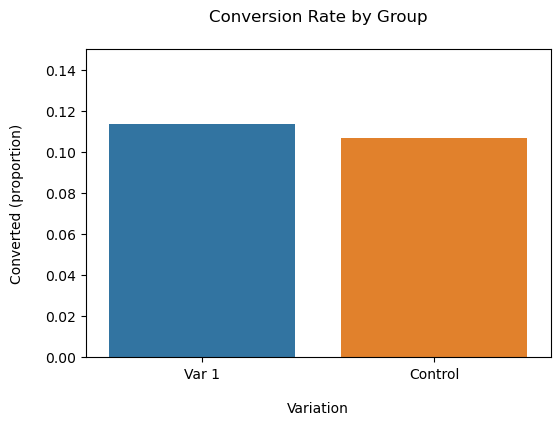

In [14]:
plt.figure(figsize=(6,4))

sns.barplot(x=ab_var1_con['variation'], y=ab_var1_con['converted'], ci=False)

plt.ylim(0,0.15)
plt.title('Conversion Rate by Group', pad=20)
plt.xlabel('Variation', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

## Figure 2: Var 2 vs Control Group (Bar Plot)

C:\Users\User\AppData\Local\Temp\ipykernel_4008\4174007267.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_var2_con['variation'], y=ab_var2_con['converted'], ci=False)


Text(0, 0.5, 'Converted (proportion)')

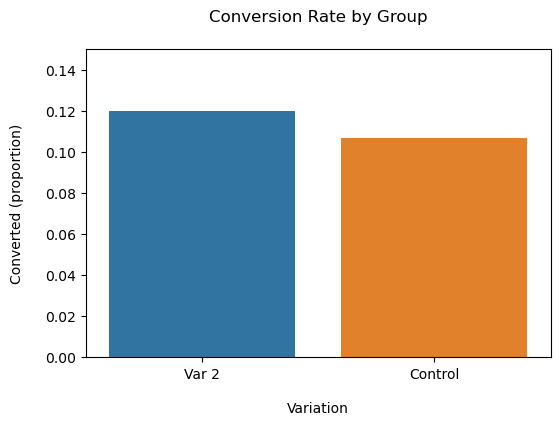

In [15]:
plt.figure(figsize=(6,4))

sns.barplot(x=ab_var2_con['variation'], y=ab_var2_con['converted'], ci=False)

plt.ylim(0,0.15)
plt.title('Conversion Rate by Group', pad=20)
plt.xlabel('Variation', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

## Figure 3: Var 3 vs Control Group (Bar Plot)

C:\Users\User\AppData\Local\Temp\ipykernel_4008\3870555431.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_var3_con['variation'], y=ab_var3_con['converted'], ci=False)


Text(0, 0.5, 'Converted (proportion)')

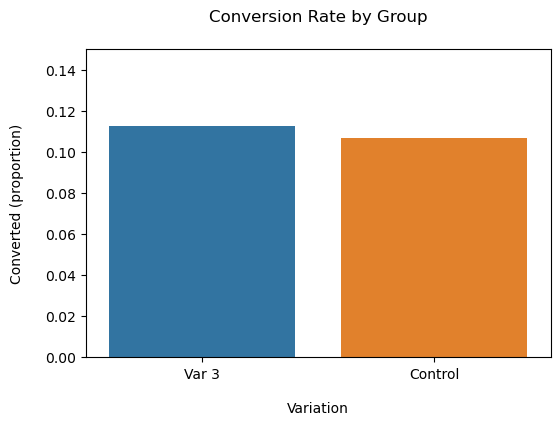

In [16]:
plt.figure(figsize=(6,4))

sns.barplot(x=ab_var3_con['variation'], y=ab_var3_con['converted'], ci=False)

plt.ylim(0,0.15)
plt.title('Conversion Rate by Group', pad=20)
plt.xlabel('Variation', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

As seen from the bar graphs above, the conversion rate of Var 2 looks more promising compared to the other two although all three variations sport increases on the conversion rates against the control group. <b>But are these increases statistically significant?</b>

# 4. Testing the Hypothesis

The details for the hypothesis have already been given above. A copy of that list is posted below.

- Null Hypothesis: The conversion rate of (Var 1: Var 2: Var 3) is the same as the conversion rate of the control group
- Alternative Hypothesis: The conversion rate of (Var 1: Var 2: Var 3) is better or worse than the conversion rate of the control group
- Confidence level: 95%; Alpha: 0.05
- Hypothesis Test: Two-Tailed Proportion
- Approach: P-value

In order to calculate for the P-value, the utlization of the proportions_ztest and proportion_confint are considered.

In [17]:
#Calculation using the Z-Test for Var 1/Control Group
var1_results = var1_df['converted']
con_results = control_df['converted']

n_con = con_results.count()
n_var1 = var1_results.count()

successes = [con_results.sum(),var1_results.sum()]
nobs = [n_con,n_var1]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con,lower_var1),(upper_con,upper_var1) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print('Z-Test Result for Var1/Control Group')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f},{upper_con:.3f}]')
print(f'ci 95% for Var 1 group: [{lower_var1:.3f}.{upper_var1:.3f}]')

Z-Test Result for Var1/Control Group
z statistic: -1.50
p-value: 0.133
ci 95% for control group: [0.101,0.113]
ci 95% for Var 1 group: [0.108.0.120]


In [18]:
#Calculation using the Z-Test for Var 2/Control Group
var2_results = var2_df['converted']
con_results = control_df['converted']

n_con = con_results.count()
n_var2 = var2_results.count()

successes = [con_results.sum(),var2_results.sum()]
nobs = [n_con,n_var2]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con,lower_var2),(upper_con,upper_var2) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print('Z-Test Result for Var2/Control Group')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f},{upper_con:.3f}]')
print(f'ci 95% for Var 2 group: [{lower_var2:.3f}.{upper_var2:.3f}]')

Z-Test Result for Var2/Control Group
z statistic: -2.90
p-value: 0.004
ci 95% for control group: [0.101,0.113]
ci 95% for Var 2 group: [0.114.0.126]


In [19]:
#Calculation using the Z-Test for Var 3/Control Group
var3_results = var3_df['converted']
con_results = control_df['converted']

n_con = con_results.count()
n_var3 = var3_results.count()

successes = [con_results.sum(),var3_results.sum()]
nobs = [n_con,n_var3]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con,lower_var3),(upper_con,upper_var3) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print('Z-Test Result for Var3/Control Group')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f},{upper_con:.3f}]')
print(f'ci 95% for Var 3 group: [{lower_var3:.3f}.{upper_var3:.3f}]')

Z-Test Result for Var3/Control Group
z statistic: -1.24
p-value: 0.216
ci 95% for control group: [0.101,0.113]
ci 95% for Var 3 group: [0.106.0.119]


Running the Z-test on the three variations, each against the control group, the significance of each increase in conversion rate is shown. Looking at the results:
- A/B Test on Var 1 and control group has a p-value of 0.133 which is way bigger than the alpha of 0.05. This means that we are to keep the Null Hypothesis.
- A/B Test on Var 2 and control group has a p-value of 0.004 which is way smaller than the alpha of 0.05. This means that we are to reject the Null Hypothesis.
- A/B Test on Var 3 and control group has a p-value of 0.216 which is also way bigger than the alpha of 0.05. This also means that we are to keep the Null Hypothesis.
The confidence interval of Var 2 also proves that its conversion rate is beyond the confidence interval of the control group, which are both at 95%.

# 5. Drawing Conclusions
The data did not support the increases in conversion rates as statistically significant for the following variations:
- New version of the landing page and new set of images
- Old version of the landing page and new set of images
Only one of the variations have a statistical significance in terms of conversion rate and is supported by the data analysed above. The Var 2 (New design of the landing page and old set of images) variation has a p-value of 0.004 which is way smaller than the alpha of 0.05. Thus, rejects the null hypothesis and supports the alternative hypothesis: <b>The conversion rate of Var 2 is better than the conversion rate of the control group</b>. As backed up by the statistics done over the data, we can affirm that the variation being affected by randomness or by chance is unlikely.

Therefore, the company must proceed to use the new design of the landing page with the old set of images on the website.
